<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/train_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-4icilo27/wavefilter_aacc47d0313a4eeab31991a8128fdd82
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-4icilo27/wavefilter_aacc47d0313a4eeab31991a8128fdd82
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for wavefilter: filename=wavefilter-0.0.1-py3-none-any.whl size=8351 sha256=08c6b5425f208f2868d1c1e4f2a752c6ab4ce33a2e67a28cbbe53a6233c713ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-ad6sjry8/wheels/90/df/9f/9270370fe3646030b374f3d85d149fae54db3182db8119bb26
Successfully built wavefilter


In [6]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import wavefilter.models as models
from wavefilter.evaluate import split_parameters, train_parallel_pulse_finder, CaptureActivations
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Make some data

In [7]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wf.datasets.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data = data[:, np.newaxis, :]
data = torch.tensor(data)
data

tensor([[[ 2.6455,  5.0103,  0.1457,  ...,  4.7056,  2.6713,  5.1927]],

        [[-2.6181, -1.6320, -2.2047,  ...,  2.7469, -2.4199, -5.8233]],

        [[-5.9268,  0.1123, -5.6525,  ..., -0.8969, -3.6743, -0.2895]],

        ...,

        [[ 0.2311,  0.8056,  1.9962,  ...,  0.1669, -0.0787, -0.1839]],

        [[ 2.8427, -0.3469,  2.0442,  ..., -0.9167, -1.5511,  1.7780]],

        [[ 2.7496, -1.2458,  0.3937,  ..., -2.2685,  2.2739,  0.6214]]])

In [8]:
ds = torch.utils.data.TensorDataset(data)
train_loader = torch.utils.data.DataLoader(ds,batch_size=100,shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7fe7c6886dd0>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7fe7ca7abef0>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7fe7c688bad0>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7fe7c688bb90>)]


## Set up the model

In [20]:
attention = models.ParallelWeightedModules()
attention.add("conv_pulse_finder", models.Conv1dPulseFinderAttention(100, False), 0)
attention.add("soft_max", models.GlobalSoftMaxAttention(), 1)

model = models.WaveFilter(200, attention).to(device)
#model = WaveFilter(200, models.GlobalSoftMaxAttention()).to(device)
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): ParallelWeightedModules(
    module_weights=(conv_pulse_finder=0,soft_max=1)
    (conv_pulse_finder): Conv1dPulseFinderAttention(
      (pulse_finder): Conv1d(1, 1, kernel_size=(100,), stride=(1,), padding=same)
      (combine): Conv1d(2, 1, kernel_size=(5,), stride=(1,), padding=same)
      (scale): Conv1d(1, 1, kernel_size=(1,), stride=(1,), padding=same)
    )
    (soft_max): GlobalSoftMaxAttention()
  )
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


In [32]:
params = split_parameters(model, ['attend'])

In [36]:
lr_schedules = [lambda x: 0.95**x, lambda x: 0.99]
tester = train_parallel_pulse_finder(ds, model, param_groups=params, lr_schedules=lr_schedules, device=device, epochs=3)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

## Inspect what we've learnt

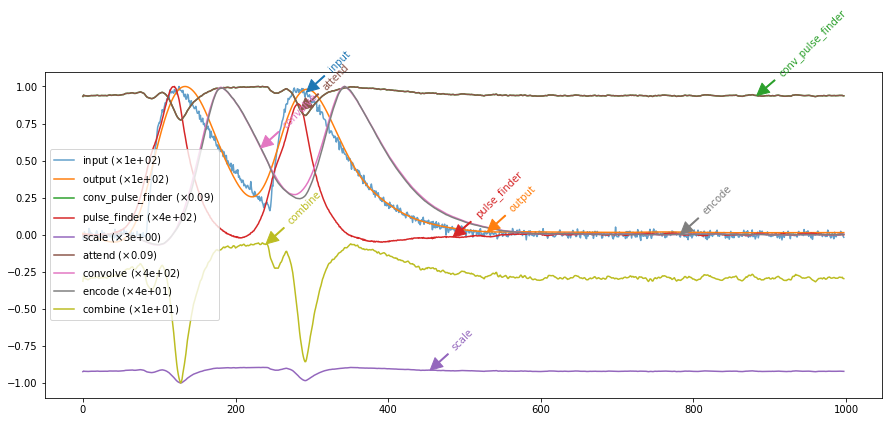

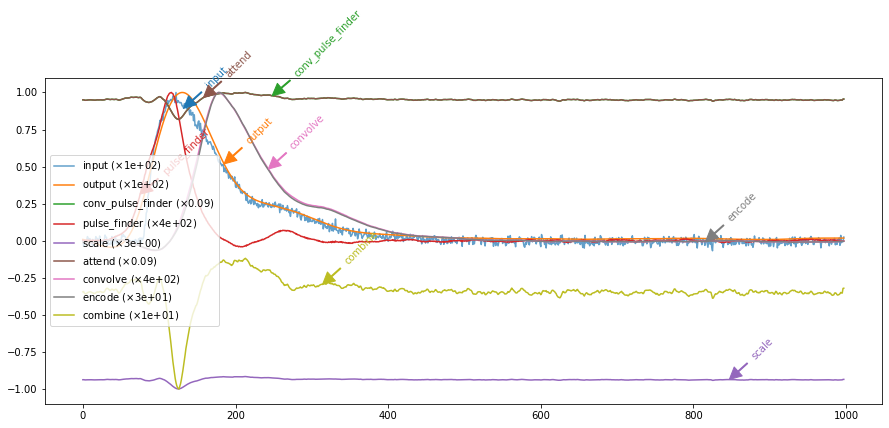

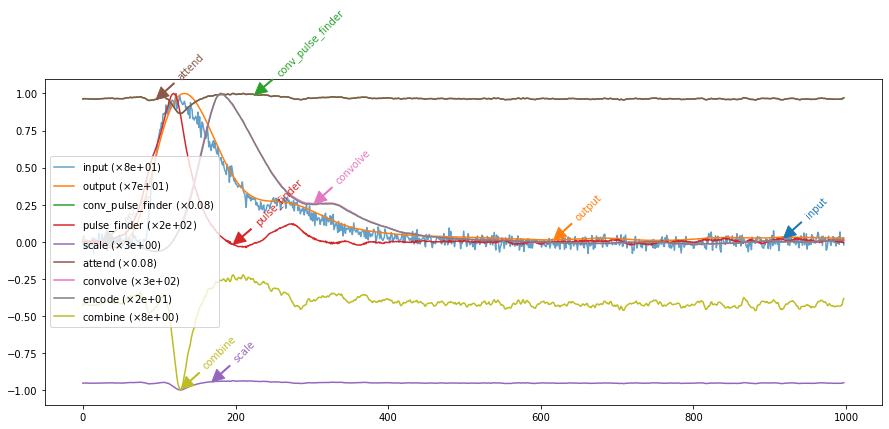

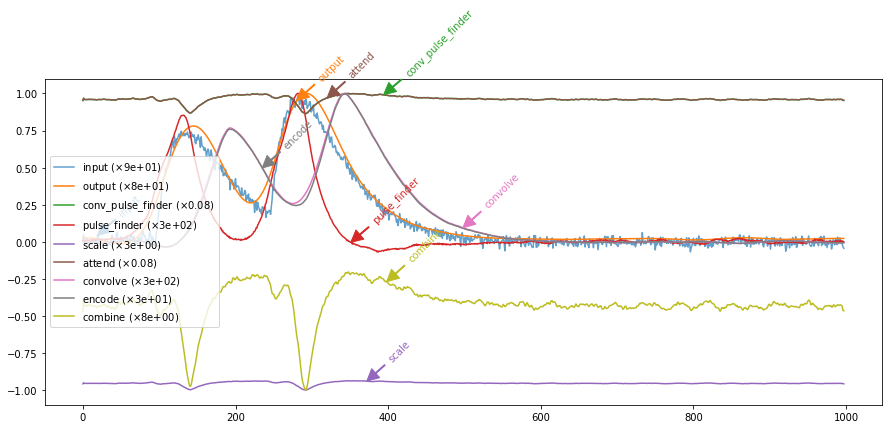

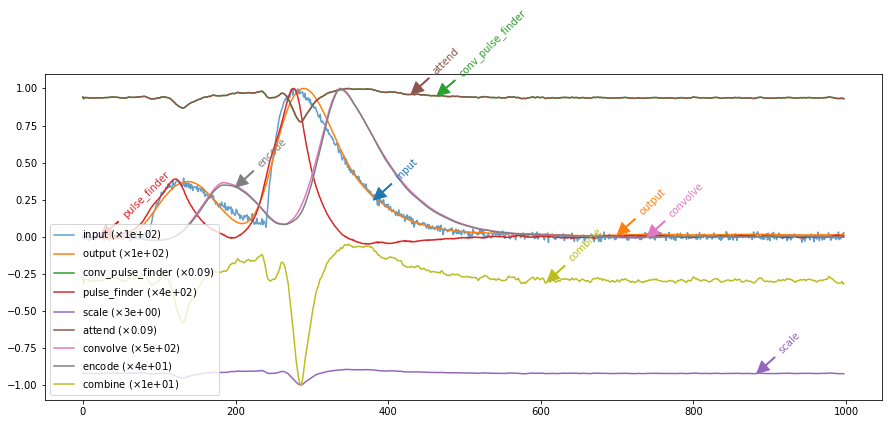

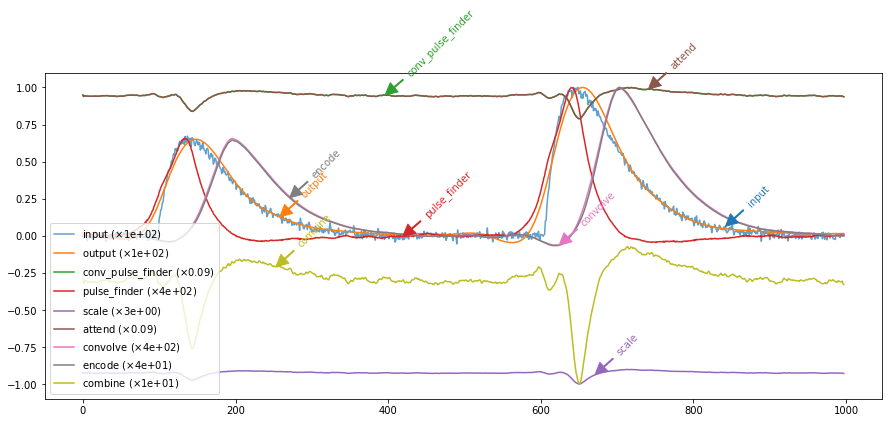

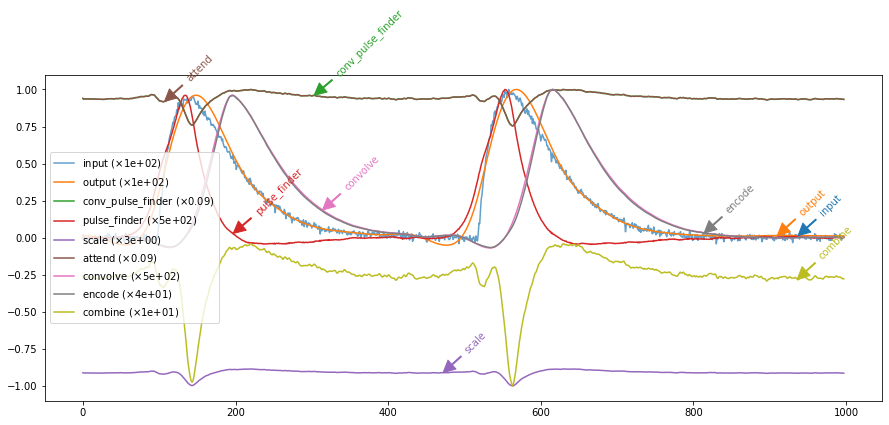

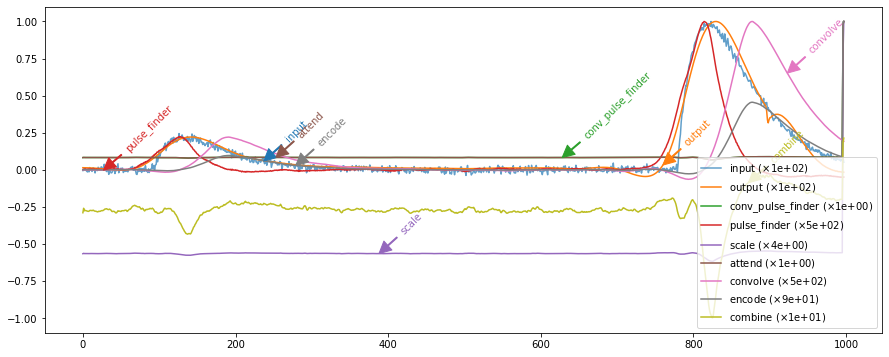

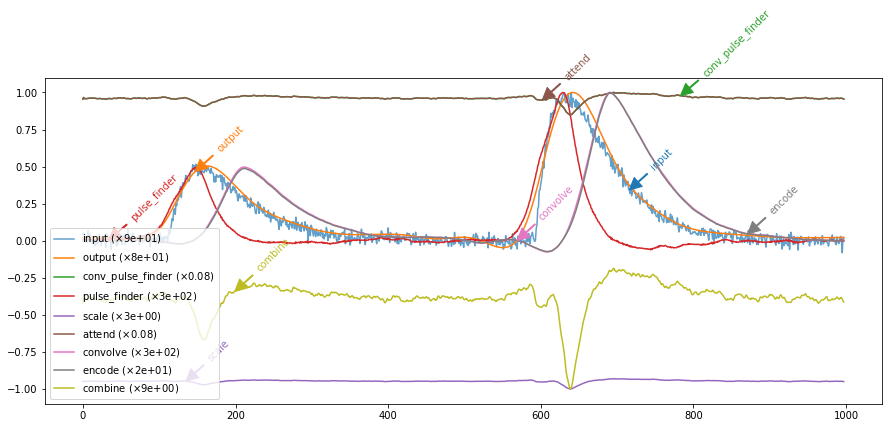

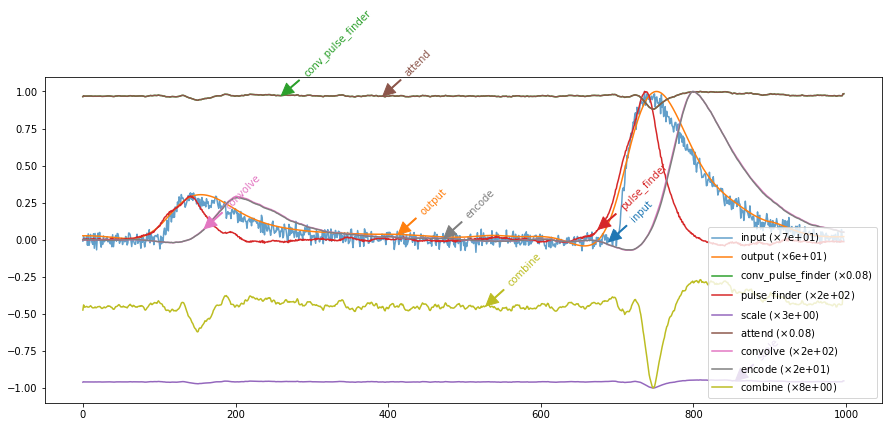

In [14]:
activations = CaptureActivations()
activations.register(model, "attend", "encode", "convolve", "reconstruct")
activations.register(model.attend, "conv_pulse_finder", "soft_max")
activations.register(model.attend.conv_pulse_finder, "pulse_finder", "combine", "scale")

def plot_line(data, label, **kwargs):
  scale = max(data.max(), -data.min())
  lines = plt.plot(data / scale, label=f"{label} ($\\times${scale:.01})", **kwargs)
  x = np.random.randint(len(data))
  y = data[x] / scale
  color = lines[0].get_color()
  plt.annotate(label, (x,y), xycoords="data", textcoords="offset points", xytext=(20,20), arrowprops=dict(width=1, color=color), color=color , rotation=45)
  

def plot_prediction(model, input):
  output = model(input.to(device))
  plot_line(input[0], label="input", alpha=0.7)
  plot_line(output[0].detach().cpu().numpy(), label="output")
  for i in ['conv_pulse_finder', 'pulse_finder', 'scale', 'attend', 'convolve' , 'encode', 'combine']:
  #for i in ['convolve', 'pulse_finder', 'combine', 'scale', 'conv_pulse_finder', 'soft_max', 'attend', 'encode', 'reconstruct']:
    plot_line(activations[i][0].cpu(), label=i)
  plt.legend()
  #plt.yscale("log")

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
for i in choices: #np.random.randint(len(data), size=10):
  plt.figure(figsize=(15,6))
  plot_prediction(model, ds[i][0])

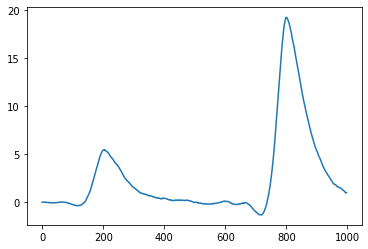

In [15]:
plt.plot(activations["encode"][0].cpu().numpy())
#plt.yscale("log")


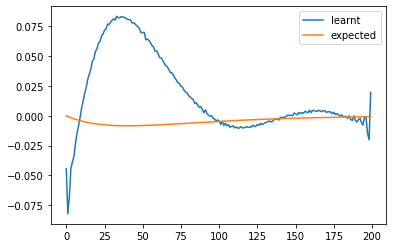

In [16]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt, label="learnt")
expected = wf.pulse_functions.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected, label="expected")
plt.legend()

1.6180801

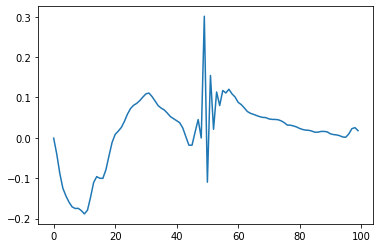

In [17]:
learnt = model.get_parameter("attend.conv_pulse_finder.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
learnt.sum()

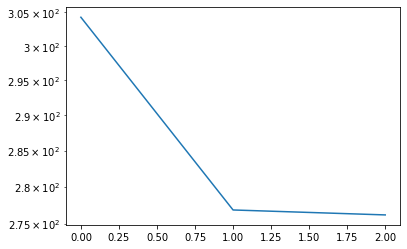

In [38]:
plt.plot(tester.train_loss);
plt.yscale("log")

In [19]:
for name, param in model.named_parameters():
  print(f"{name} = {param}")
  print()

convolve.weight = Parameter containing:
tensor([[[-4.4433e-02, -8.2193e-02, -6.7797e-02, -4.4107e-02, -3.8779e-02,
          -3.4020e-02, -2.3176e-02, -1.4387e-02, -8.5847e-03, -1.3825e-03,
           6.3903e-03,  1.2063e-02,  1.8507e-02,  2.3581e-02,  3.0474e-02,
           3.4820e-02,  3.8826e-02,  4.5632e-02,  4.7661e-02,  5.3857e-02,
           5.5921e-02,  6.0883e-02,  6.2037e-02,  6.6934e-02,  6.8474e-02,
           7.1686e-02,  7.2843e-02,  7.6755e-02,  7.6499e-02,  7.8456e-02,
           8.0103e-02,  8.1297e-02,  8.0167e-02,  8.3397e-02,  8.2168e-02,
           8.2166e-02,  8.2977e-02,  8.2958e-02,  8.2209e-02,  8.1716e-02,
           8.0831e-02,  8.0529e-02,  8.0246e-02,  7.7820e-02,  7.7938e-02,
           7.6945e-02,  7.5383e-02,  7.4344e-02,  7.2578e-02,  6.9452e-02,
           6.9788e-02,  6.9885e-02,  6.3613e-02,  6.4326e-02,  6.3211e-02,
           6.1323e-02,  5.8994e-02,  5.7578e-02,  5.4284e-02,  5.4474e-02,
           5.2044e-02,  4.8851e-02,  4.8462e-02,  4.6471e-02